In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from tqdm.auto import tqdm, trange
import xgboost as xgb
import joblib

from src.model import tscv
from src.feature_engineering import get_feature_cols

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.1
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2


# Feature importances

Our models are not improving that greatly from adding the features as I thought they would and our best result was using just the mean encodings. Because of that I decided to further investigate it by looking into feature importances.

Firstly let's load the model we'll study and the feature set we used to train it.

In [2]:
train_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set-features-005.parquet'))
reg = joblib.load(os.path.join(MODELS_DIR, 'xgb-features-005.model'))

In [3]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.63,
             colsample_bynode=0.37, colsample_bytree=0.62, gamma=0, gpu_id=0,
             grow_policy='lossguide', importance_type='gain',
             interaction_constraints='', learning_rate=0.009590957320648831,
             max_delta_step=0, max_depth=11, min_child_weight=6, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=371, n_jobs=-1, num_parallel_tree=1,
             random_state=918429, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=918429, subsample=0.5, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [4]:
train_set.describe()

,item_id,shop_id,date_block_num,item_cnt_month,month_id,year_id,f__cat__date_block_num,f__cat__month_id,f__cat__year_id,f__item_cnt_1,...,MOEX_low,MOEX_close,MOEX_gain,CNYRUB_gain,USDRUB_gain,EURRUB_gain,f__MOEX_gain,f__CNYRUB_gain,f__USDRUB_gain,f__EURRUB_gain
count,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,...,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06,5.140800e+06
mean,1.101940e+04,3.164286e+01,2.150000e+01,2.199702e-01,5.500000e+00,1.333333e+00,2.150000e+01,5.500000e+00,1.333333e+00,2.524142e-01,...,1.461943e+03,1.536246e+03,1.005411e+00,1.026837e+00,1.028677e+00,1.020173e+00,1.005411e+00,1.026837e+00,1.028677e+00,1.020173e+00
std,6.252631e+03,1.756189e+01,6.922187e+00,1.113889e+00,3.452053e+00,6.236096e-01,6.922187e+00,3.452053e+00,6.236096e-01,3.386479e+00,...,1.307521e+02,1.281704e+02,4.523354e-02,7.167436e-02,7.419862e-02,6.774523e-02,4.523354e-02,7.167436e-02,7.419862e-02,6.774523e-02
min,3.000000e+01,2.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,-4.000000e+00,...,1.182890e+03,1.306010e+03,9.243598e-01,8.677034e-01,8.708186e-01,8.658117e-01,9.243598e-01,8.677034e-01,8.708186e-01,8.658117e-01
25%,5.381500e+03,1.600000e+01,1.575000e+01,0.000000e+00,2.750000e+00,1.000000e+00,1.575000e+01,2.750000e+00,1.000000e+00,0.000000e+00,...,1.356155e+03,1.441540e+03,9.608122e-01,9.834354e-01,9.782704e-01,9.794061e-01,9.608122e-01,9.834354e-01,9.782704e-01,9.794061e-01
50%,1.120300e+04,3.450000e+01,2.150000e+01,0.000000e+00,5.500000e+00,1.000000e+00,2.150000e+01,5.500000e+00,1.000000e+00,0.000000e+00,...,1.460185e+03,1.495930e+03,1.012590e+00,1.024175e+00,1.025518e+00,1.016088e+00,1.012590e+00,1.024175e+00,1.025518e+00,1.016088e+00
75%,1.607150e+04,4.700000e+01,2.725000e+01,0.000000e+00,8.250000e+00,2.000000e+00,2.725000e+01,8.250000e+00,2.000000e+00,0.000000e+00,...,1.603540e+03,1.649405e+03,1.038881e+00,1.067342e+00,1.077599e+00,1.072480e+00,1.038881e+00,1.067342e+00,1.077599e+00,1.072480e+00
max,2.216700e+04,5.900000e+01,3.300000e+01,2.000000e+01,1.100000e+01,2.000000e+00,3.300000e+01,1.100000e+01,2.000000e+00,1.305000e+03,...,1.616320e+03,1.758970e+03,1.097400e+00,1.178710e+00,1.186605e+00,1.139024e+00,1.097400e+00,1.178710e+00,1.186605e+00,1.139024e+00


In [5]:
reg.feature_importances_

array([0.01017479, 0.01504157, 0.01169381, 0.18179962, 0.08062389,
       0.08181904, 0.05059277, 0.0556238 , 0.02858131, 0.02942465,
       0.02513589, 0.02722371, 0.02191895, 0.0130092 , 0.01594402,
       0.01109055, 0.00753304, 0.00701051, 0.00643709, 0.00715892,
       0.00559693, 0.00442607, 0.0038952 , 0.00450655, 0.00669126,
       0.0034774 , 0.00480454, 0.00310033, 0.00311655, 0.00355967,
       0.00248   , 0.00274835, 0.002108  , 0.00226018, 0.00200726,
       0.00400991, 0.00359668, 0.00316779, 0.00337554, 0.00337634,
       0.00333253, 0.00327846, 0.00352567, 0.00348227, 0.00350901,
       0.00336433, 0.00344081, 0.00336667, 0.0034641 , 0.0035858 ,
       0.00354388, 0.00290901, 0.00303307, 0.00300395, 0.00338789,
       0.00353771, 0.00346448, 0.00358962, 0.00337608, 0.0032897 ,
       0.00321617, 0.00330857, 0.00325971, 0.00323551, 0.0032322 ,
       0.00328895, 0.00334698, 0.00563243, 0.00740989, 0.007593  ,
       0.0102    , 0.00697779, 0.0064136 , 0.00586899, 0.00616

In [7]:
feature_importances = pd.DataFrame({'feature_name': get_feature_cols(train_set)[sort_idx],
                                    'importance': reg.feature_importances_})

In [8]:
feature_importances

,feature_name,importance
0,f__item_cnt_1,0.010175
1,f__item_cnt_3,0.015042
2,f__item_cnt_2,0.011694
3,f__item_cnt_5,0.181800
4,f__item_cnt_4,0.080624
...,...,...
82,f__item_cnt_29,0.008417
83,f__item_cnt_28,0.007370
84,f__item_cnt_31,0.007451
85,f__item_cnt_30,0.007162


<AxesSubplot:ylabel='feature_name'>

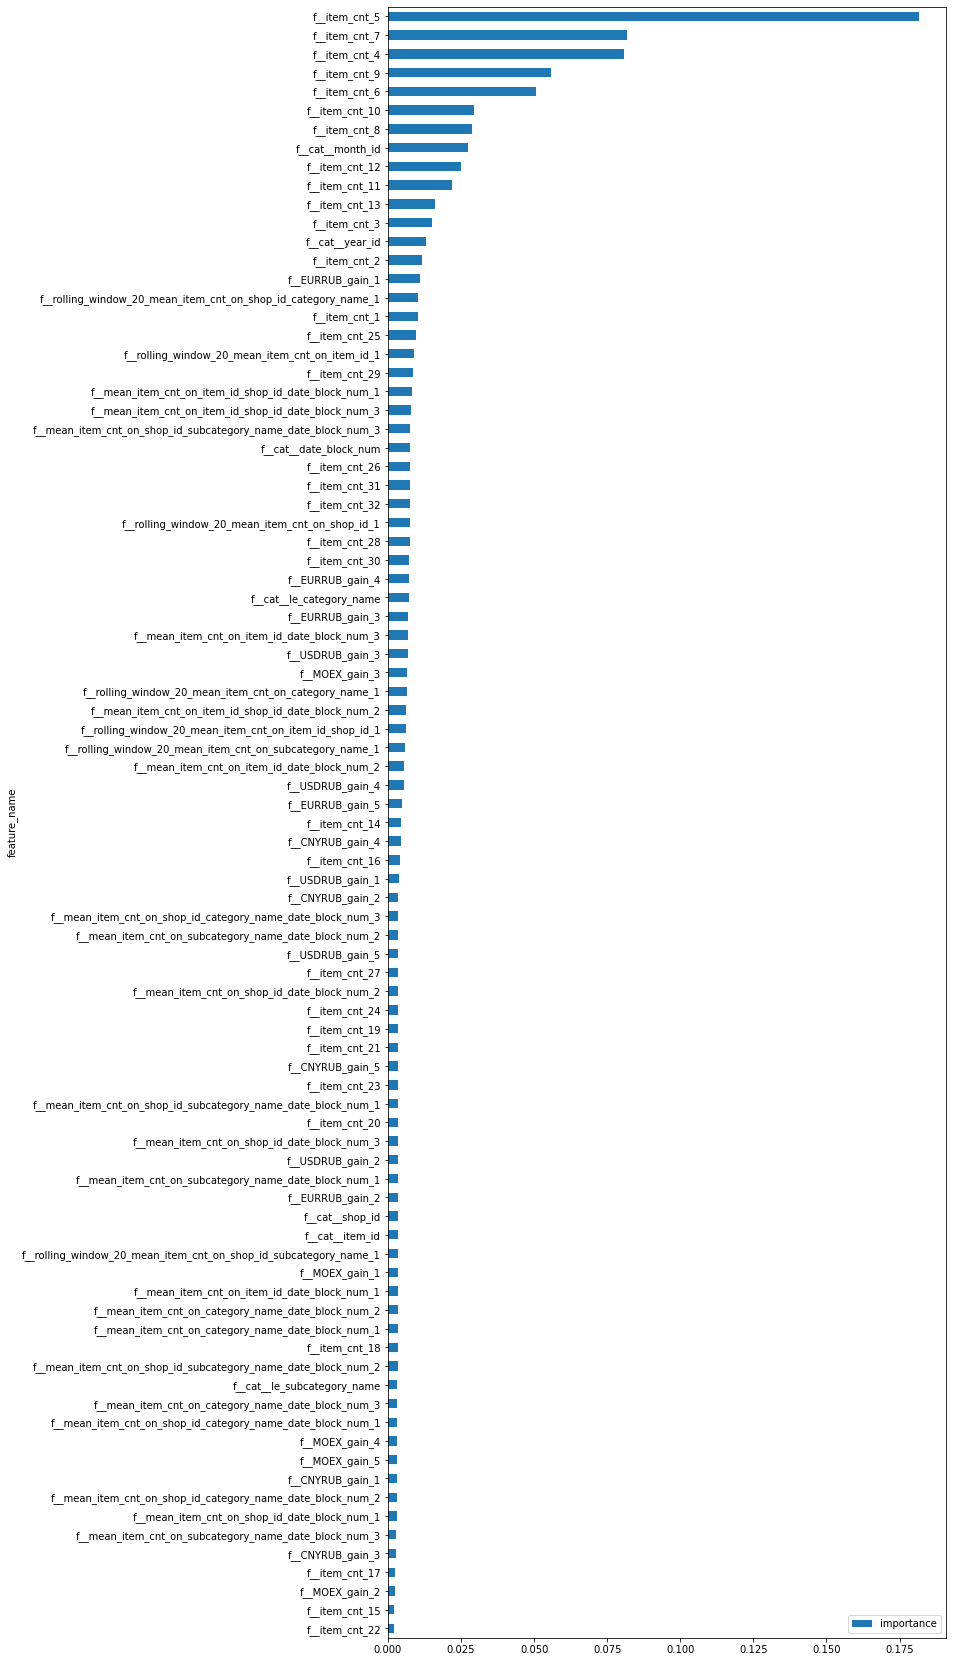

In [19]:
# sns.barplot(data=feature_importances.sort_values('importance', ascending=False), x='importance', y='feature_name')
feature_importances.set_index('feature_name').sort_values('importance', ascending=True).plot(kind='barh', figsize=(10, 30))

We can see item counts dominate the featue importances.